<a href="https://colab.research.google.com/github/matchbou/kaggle-study-20190410/blob/master/LightGBM-Titanic-Kaggle-201904162031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://www.kaggle.com/currypurin/lightgbm-titanic

# LightGBM-Titanic

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matchbou","key":"1d8d5134664762f7504a621f52d4e0cb"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!pip install kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# kaggleデータ置き場とjupyernoteのカレントディレクトリフォルダを作成

!mkdir ./input
!mkdir ./notebook

In [8]:
#osライブラリ読込してinputに移動⇒kaggleデータもダウンロード　⇒ notebookフォルダに移動
import os
os.chdir('input')

#https://www.kaggle.com/c/titanic/data
!kaggle competitions download -c titanic

os.chdir('../notebook')


  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 52.0MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 27.6MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.91MB/s]


In [9]:
#上記操作の結果以下のディレクトリ配置となる

# /content/notebook このipynbのカレントディレクトリ
# /content/input カグルからダウンロードしたcsvファイルの置き場所

!pwd
!ls -a ../input


/content/notebook
.  ..  gender_submission.csv  test.csv	train.csv


In [0]:
#ここからカーネルの内容に踏み込む

In [0]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt


In [12]:
ls ../input

gender_submission.csv  test.csv  train.csv


In [0]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_gender_submission = pd.read_csv('../input/gender_submission.csv')

In [0]:
genders = {'male': 0, 'female': 1} # 辞書を作成
# Sexをgendersを用いて変換
df_train['Sex'] = df_train['Sex'].map(genders)
df_test['Sex'] = df_test['Sex'].map(genders)

# ダミー変数化
df_train = pd.get_dummies(df_train, columns=['Embarked'])
df_test = pd.get_dummies(df_test, columns = ['Embarked'])

# 不要な列の削除
df_train.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

In [15]:
df_train.head(6)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,1,38.0,1,0,71.2833,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,1
5,0,3,0,NaN,0,0,8.4583,0,1,0


In [0]:
X_train = df_train.iloc[:, 1:]
Y_train = df_train['Survived']

In [17]:
# 3分割交差検証を指定し、インスタンス化
kf = KFold(n_splits=3)

score_list = []


pred = np.zeros(len(df_test))

for train_index, test_index in kf.split(X_train, Y_train):
    X_cv_train = X_train.iloc[train_index]
    X_cv_test = X_train.iloc[test_index]
    y_cv_train = Y_train[train_index]
    y_cv_test = Y_train[test_index]

    gbm = lgb.LGBMClassifier(objective='binary',
                             num_leaves=300,
                             learning_rate=0.1,
                             random_seed=1,
                             max_depth=2
                            )
    gbm.fit(X_cv_train, y_cv_train,
            eval_set = [(X_cv_test, y_cv_test)],
            early_stopping_rounds=20,
            verbose=5)
    
    y_pred = gbm.predict(X_cv_test, num_iteration=gbm.best_iteration_)
    score_list.append(round(accuracy_score(y_cv_test,y_pred)*100,2))
    print(round(accuracy_score(y_cv_test,y_pred)*100,2))
    pred += gbm.predict(df_test, num_iteration=gbm.best_iteration_)/3
pred = (pred > 0.5).astype(np.int)

Training until validation scores don't improve for 20 rounds.
[5]	valid_0's binary_logloss: 0.548388
[10]	valid_0's binary_logloss: 0.502754
[15]	valid_0's binary_logloss: 0.485102
[20]	valid_0's binary_logloss: 0.473019
[25]	valid_0's binary_logloss: 0.468372
[30]	valid_0's binary_logloss: 0.460954
[35]	valid_0's binary_logloss: 0.459044
[40]	valid_0's binary_logloss: 0.45735
[45]	valid_0's binary_logloss: 0.456929
[50]	valid_0's binary_logloss: 0.456482
[55]	valid_0's binary_logloss: 0.455615
[60]	valid_0's binary_logloss: 0.455277
[65]	valid_0's binary_logloss: 0.455769
[70]	valid_0's binary_logloss: 0.45557
[75]	valid_0's binary_logloss: 0.458139
[80]	valid_0's binary_logloss: 0.457811
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.454254
82.15
Training until validation scores don't improve for 20 rounds.
[5]	valid_0's binary_logloss: 0.542088
[10]	valid_0's binary_logloss: 0.481404
[15]	valid_0's binary_logloss: 0.45383
[20]	valid_0's binary_logloss: 0.439588


In [18]:
gbm.predict_proba(X_cv_test, num_iteration=gbm.best_iteration_)

array([[0.84191284, 0.15808716],
       [0.79006203, 0.20993797],
       [0.12974725, 0.87025275],
       [0.94351862, 0.05648138],
       [0.87784124, 0.12215876],
       [0.78294935, 0.21705065],
       [0.15597666, 0.84402334],
       [0.8684135 , 0.1315865 ],
       [0.74468497, 0.25531503],
       [0.8661755 , 0.1338245 ],
       [0.58236522, 0.41763478],
       [0.76813227, 0.23186773],
       [0.84053105, 0.15946895],
       [0.66091444, 0.33908556],
       [0.09138137, 0.90861863],
       [0.11698828, 0.88301172],
       [0.54883394, 0.45116606],
       [0.93333773, 0.06666227],
       [0.26581796, 0.73418204],
       [0.87784124, 0.12215876],
       [0.80898979, 0.19101021],
       [0.11496274, 0.88503726],
       [0.82747377, 0.17252623],
       [0.47812504, 0.52187496],
       [0.05311793, 0.94688207],
       [0.83680952, 0.16319048],
       [0.84715709, 0.15284291],
       [0.74233081, 0.25766919],
       [0.79289128, 0.20710872],
       [0.83650124, 0.16349876],
       [0.

In [20]:
gbm.get_params

<bound method LGBMModel.get_params of LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=2,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=300, objective='binary',
        random_seed=1, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)>

In [21]:
score_list

[82.15, 83.5, 83.16]

In [0]:
df_gender_submission['Survived'] = pred

In [0]:
df_gender_submission.to_csv('lightgbm.csv',index = False)

In [24]:
X_train = df_train.iloc[:,1:]
Y_train = df_train['Survived']

# 3分割交差検証を指定し、インスタンス化
skf = KFold(n_splits=3)

# skf.split(X_train.Ytrain)で、X_trainとY_trainを3分割し、交差検証をする
for train_index, test_index in skf.split(X_train, Y_train):
    X_cv_train = X_train.iloc[train_index]
    X_cv_test = X_train.iloc[test_index]
    y_cv_train = Y_train[train_index]
    y_cv_test = Y_train[test_index]
    
    lgb_train = lgb.Dataset(X_cv_train,y_cv_train)
    lgb_eval = lgb.Dataset(X_cv_test,y_cv_test)
    
    lgbm_params = {
        # 多値分類問題
        'objective': 'binary',
    }
    
    gbm = lgb.train(params = lgbm_params,
            train_set = lgb_train,
            num_boost_round=50,
            valid_sets=lgb_eval,
            early_stopping_rounds=20,
            verbose_eval = 5)
    
    y_pred = gbm.predict(X_cv_test,num_iteration=gbm.best_iteration)

    # acuuracyを表示
    preds = np.round(gbm.predict(X_cv_test))
    print(round(accuracy_score(y_cv_test,preds)*100,2))

Training until validation scores don't improve for 20 rounds.
[5]	valid_0's binary_logloss: 0.539266
[10]	valid_0's binary_logloss: 0.498639
[15]	valid_0's binary_logloss: 0.482375
[20]	valid_0's binary_logloss: 0.469822
[25]	valid_0's binary_logloss: 0.470981
[30]	valid_0's binary_logloss: 0.476095
[35]	valid_0's binary_logloss: 0.484826
[40]	valid_0's binary_logloss: 0.491263
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.468911
81.48
Training until validation scores don't improve for 20 rounds.
[5]	valid_0's binary_logloss: 0.52619
[10]	valid_0's binary_logloss: 0.462726
[15]	valid_0's binary_logloss: 0.436404
[20]	valid_0's binary_logloss: 0.428472
[25]	valid_0's binary_logloss: 0.429528
[30]	valid_0's binary_logloss: 0.438034
[35]	valid_0's binary_logloss: 0.450534
[40]	valid_0's binary_logloss: 0.461006
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.427376
82.49
Training until validation scores don't improve for 20 rounds.
[5]	valid_0's b

In [0]:
lgb_train = lgb.Dataset(X_train, Y_train)

# LightGBM のハイパーパラメータ
lgbm_params = {
    # ２値分類問題
    'objective': 'binary',
}

In [26]:
lgb.cv

<function lightgbm.engine.cv>

In [27]:
gbm = lgb.cv(lgbm_params,
             train_set = lgb_train,
             nfold=3,
             verbose_eval=10)

[10]	cv_agg's binary_logloss: 0.470409 + 0.00885763
[20]	cv_agg's binary_logloss: 0.433319 + 0.0114559
[30]	cv_agg's binary_logloss: 0.43004 + 0.00799587
[40]	cv_agg's binary_logloss: 0.441298 + 0.0126265
[50]	cv_agg's binary_logloss: 0.450295 + 0.0150997
[60]	cv_agg's binary_logloss: 0.458109 + 0.0198328
[70]	cv_agg's binary_logloss: 0.465633 + 0.0230839
[80]	cv_agg's binary_logloss: 0.469289 + 0.0243248
[90]	cv_agg's binary_logloss: 0.473361 + 0.0242195
[100]	cv_agg's binary_logloss: 0.482202 + 0.0235787


In [28]:
gbm # 辞書にlossとlossの標準偏差がはいります。

{'binary_logloss-mean': [0.6244676530699209,
  0.591378708000547,
  0.5646871408403941,
  0.5430794364047018,
  0.5255972052117025,
  0.5105782240063957,
  0.498630252640163,
  0.48766260104521236,
  0.4794180403512449,
  0.47040882129283723,
  0.4645830108398152,
  0.45906423658181694,
  0.45353088053802476,
  0.4490502510197449,
  0.4460574841508103,
  0.44209051881915645,
  0.4384397631075197,
  0.43686488624925984,
  0.4345050298548725,
  0.43331935391745785,
  0.4323438948902269,
  0.4315994772300991,
  0.42987718410776093,
  0.42864341582084536,
  0.4287193410247751,
  0.4283668337394433,
  0.4283807327118648,
  0.42867040293706965,
  0.42881029405371596,
  0.43003966045540604,
  0.4309637813099401,
  0.432513032322477,
  0.43345132486387533,
  0.4346830139000119,
  0.43671569283960493,
  0.43759335812175104,
  0.4382512358333317,
  0.4388984076590239,
  0.4402321532509546,
  0.4412980187877033,
  0.44330882957048967,
  0.4439840105630075,
  0.4448680686218101,
  0.44522747861204

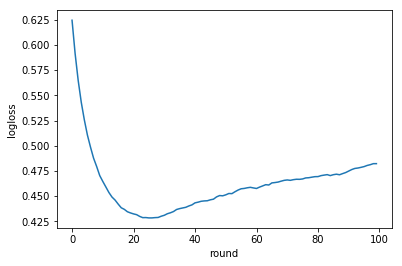

In [29]:
cv_logloss = gbm['binary_logloss-mean']
round_n = np.arange(len(cv_logloss))

plt.xlabel('round')
plt.ylabel('logloss')
plt.plot(round_n, cv_logloss)
plt.show()

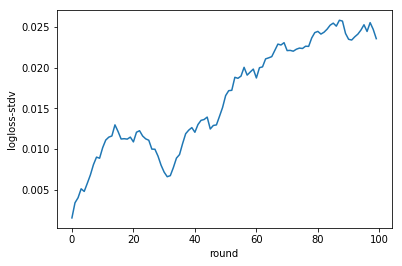

In [30]:
plt.xlabel('round')
plt.ylabel('logloss-stdv')
plt.plot(round_n, gbm['binary_logloss-stdv']);
plt.show()